# Neural Network Builder

In [48]:
#nbi:hide_in
import pandas_datareader as pd2
import pandas as pd
import tensorflow
import keras as ks
import matplotlib.pyplot as mp
from matplotlib import animation
from keras.layers import Dense,LSTM,Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping,Callback
import numpy as np
from ipywidgets import interact,interact_manual

In [2]:
#nbi:hide_in
#WE DECLARE OUR CLASSES
#THIS FUNCTION GETS, WINDOWS AND SPLITS INTO TEST/TRAIN
class Data():
    
    def __init__(self,ticker,start,end):
        self.data = pd2.DataReader(ticker,'yahoo', start, end).iloc[:,]
        
    def window(self,windows,col):
        
        #we sort the windowed array
        windows = sorted(windows)

        #we loop through the training data and restructure
        for i in range(max(windows),self.data.count()[0]):

            y_record = self.data.iloc[[i],:].loc[:,[col]]
            x_record = self.data.iloc[[i-windows[0]],:].loc[:,[col]]
            x_record.columns = str(windows[0]) + "-" + x_record.columns

            if(len(windows)>1):

                for j in range(1,len(windows)):
                    x_temp   = self.data.iloc[[i-windows[j]],:].loc[:,[col]]
                    x_temp.columns = str(windows[j]) + "-" + x_temp.columns
                    x_record = pd.concat([x_record.reset_index(drop=True), x_temp.reset_index(drop=True)], axis=1)

            if(i==max(windows)):
                x_final = x_record
                y_final = y_record
            else:
                x_final = x_final.append(x_record)
                y_final = y_final.append(y_record)

            self.features = x_final.set_index(y_final.index)
            self.response = y_final
            
    def split_data(self,period):
        self.test_features = self.features.iloc[self.features.count()[0]-period:self.features.count()[0],:]
        self.train_features = self.features.iloc[0:self.features.count()[0]-period,:]
        self.test_response = self.response.iloc[self.features.count()[0]-period:self.features.count()[0],:]
        self.train_response = self.response.iloc[0:self.features.count()[0]-period,:]
        self.data_train = self.data.iloc[0:self.data.count()[0]-period,:]
        self.data_test =  self.data.iloc[self.data.count()[0]-period:self.data.count()[0],:]

class NN():
    
    def __init__(self,neurons,activations):
        self.neurons = neurons
        self.activations = activations
     
    def create_model(self,dim,loss,optimizer):
    
        self.model = ks.Sequential()
     
        for i in range(0,len(self.neurons)):
            neuron = self.neurons[i]
            activation = self.activations[i]
        
            if(i == 0):
                self.model.add(Dense(neuron,input_dim = dim,activation = activation))
            else:
                self.model.add(Dense(neuron,activation = activation))
                
        self.model.compile(loss=loss,optimizer=optimizer)
        
        
class OutputObserver(Callback):

    def __init__(self, train,test,batch):
        self.out_log = []
        self.out_log2 = []
        self.train = train
        self.test = test
        self.batch = batch

    def on_epoch_end(self, epoch, logs={}):
        self.out_log.append(self.model.predict(self.train, batch_size=self.batch))
        self.out_log2.append(self.model.predict(self.test, batch_size=self.batch))

## Data Import
    
This window allows you to import ticker information for any period of time. It then allows you to split the data into training and validation, as well as window periods. Specifically, the arguments allowed for are:

    - Ticker     : This is the symbol you wish to download data for, e.g. AAPL
    - start      : This is the first date for the ticker
    - end        : This is the end date of the ticker
    - window     : Which period do you wish to use to predict? For example, the opening price 7,30 and 60 days ago
    - validation : How many days to you wish to set aside as a validation set?

Please enter the arguments required, in the format shown below, in order to download and import the required data.

In [3]:
#nbi:hide_in
ticker = ''
start = ''
end = ''
windows = ''
validation = ''

#This stores variables for data extract
def data_store(ticker_in = 'NA',start_in = 'NA',end_in = 'NA', window = 'NA', valid = 'NA'):
    
    global ticker
    global start
    global end
    global windows
    global validation
    

    ticker = ticker_in
    start = start_in
    end  = end_in
    windows = list(map(int,window.split(',')))
    validation = int(valid)


#This extracts the data
def data_build():
    
    global data

    #we create the data model
    data = Data(ticker,start,end)
    data.window(windows,'Open')
    data.split_data(validation)
    #we plot the training and test
    mp.figure(1)
    mp.plot(data.train_response)
    mp.plot(data.test_response)
    mp.title('Train and Validation Split')
    
    #we plot the windowed data
    mp.figure(2)
    mp.plot(data.train_features)
    mp.title('Training windowed data')


interact(data_store,ticker_in ='AAPL',start_in ='2012-04-04',end_in ='2016-04-04',window='30,60,90',valid='90')
interact_manual(data_build)

interactive(children=(Text(value='AAPL', description='ticker_in'), Text(value='2012-04-04', description='start…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

<function __main__.data_build()>

## Neural Network Builder

This section allows you to build a simple, dense layer neural network on the above loaded data. Specifically, it allows you control over the following parameters:

    - Neurons     : How many layers, and how many neurons per layer? Please note there should be 1 neuron in the final layer
    - Activations : Which activation function will each layer use?
    - Epochs      : How many epochs will the model run for?
    - Batch size  : What is the batch size of the model?
    - Verbose     : Should the model output interim results? 1 is true, 0 is false.
    - EarlyStop   : Should the model stop when validation error is optimized?
    
It's easier than it looks! Have fun!

In [4]:
#nbi:hide_in
limit  = 100
neuron_array = ''
activation_array =''
epochs = ''
batch_size =''
verbose = ''
earlystop = ''
network = ''
history = ''
Log = ''

def neural_network_store(neurons,activations,epoch_in,batch_size_in,verbose_in,early_stop):
    global  neuron_array 
    global  activation_array 
    global  epochs
    global  limit
    global  batch_size 
    global  verbose
    global  earlystop
    
    #organize inputs
    try:
        neuron_array = list(map(int,neurons.split(',')))
    except:
        pass

    try:
        activation_array = activations.split(',')
    except:
        pass

    try:
        epochs = int(epoch_in)
        limit = epochs
    except:
        pass

    try:
        batch_size = int(batch_size_in)
    except:
        pass

    try:
        verbose = int(verbose_in)
    except:
        pass

    try:
        earlystop = early_stop
    except:
        pass
    
def neural_network_build():
    global network
    global history
    global limit
    global Log
    global Stop
    global epochs
    
    network = NN(neuron_array,activation_array)
    network.create_model(dim=data.train_features.shape[1],loss='mse',optimizer='adam')
    Stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='auto', baseline=None)
    Log  = OutputObserver(train = data.train_features,test = data.test_features, batch = batch_size)

    if earlystop == True:
        history = network.model.fit(data.train_features,data.train_response.loc[:,'Open'],epochs=epochs,batch_size=batch_size,verbose=verbose,callbacks=[Stop,Log],validation_data = (data.test_features,data.test_response.loc[:,'Open']))
    else:
        history = network.model.fit(data.train_features,data.train_response.loc[:,'Open'],epochs=epochs,batch_size=batch_size,verbose=verbose,callbacks=[Log],validation_data = (data.test_features,data.test_response.loc[:,'Open']))
        
    #we plot the training and test
    mp.figure(1)
    mp.plot(data.train_response.index,network.model.predict(data.train_features))
    mp.plot(data.train_response)
    mp.title('Training and Prediction')
    
    #we plot the training and test
    mp.figure(2)
    mp.plot(data.test_response.index,network.model.predict(data.test_features))
    mp.plot(data.test_response)
    mp.title('Validation and Prediction')
    
    #we plot the training and test
    mp.figure(3)
    mp.plot(history.history['val_loss'])
    mp.plot(history.history['loss'])
    mp.title('Training and Validation Error')
    
    limit = (np.array(Log.out_log)).shape[0]
    

interact(neural_network_store,neurons ='50,50,30,30,1',activations = 'sigmoid,linear,sigmoid,linear,linear',epoch_in = '1000',batch_size_in ='50',verbose_in = '0',early_stop = True)
interact_manual(neural_network_build)


interactive(children=(Text(value='50,50,30,30,1', description='neurons'), Text(value='sigmoid,linear,sigmoid,l…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

<function __main__.neural_network_build()>

## Performance over the time
The following section allows you to observe the performance of your network as a function of the training epoch. Click the button to cycle through all epochs:

### Training performance

In [46]:
#nbi:hide_in
def plot_performance():
  
    try:
        fig = mp.figure()
        ax  = fig.add_subplot(111)

        for i in range(0,np.array(Log.out_log).shape[0]-1):
            if i == 0:
                line1, = ax.plot(data.train_response.index,np.array(Log.out_log)[i], 'r-')
                line2, = ax.plot(data.train_response.index,data.train_response, 'b-')
                mp.title('Training and Prediction')
                fig.canvas.draw()
                fig.canvas.flush_events()
            else:
                mp.pause(1)
                line1.set_ydata = np.array(Log.out_log)[i]
                fig.canvas.draw()
                fig.canvas.flush_events()
    except:
        pass
            
interact_manual(plot_performance)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

<function __main__.plot_performance()>

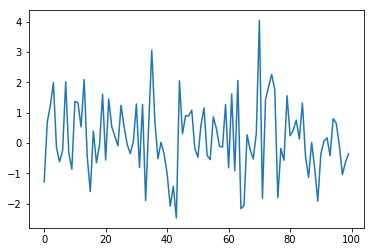

In [ ]:
import pylab as pl
from IPython import display

for i in range(10):
    mp.plot(pl.randn(100))
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)

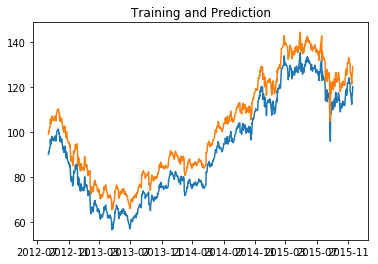

In [29]:
a = mp.figure(1)
mp.plot(data.train_response.index,data.train_response+1)
mp.plot(data.train_response.index,data.train_response+10)
mp.title('Training and Prediction')
mp.pause(0.01)
mp.clf()
mp.cla()
mp.close()

### Test performance

In [5]:
#nbi:hide_in
def plot_performance_2():
  
    try:
        for i in range(0,np.array(Log.out_log).shape[0]-1):
            mp.figure(1)
            mp.plot(data.test_response.index,np.array(Log.out2_log)[i])
            mp.plot(data.test_response.index,data.test_response)
            mp.title('Test and Prediction')
            mp.pause(1)
    except:
        pass
            
interact_manual(plot_performance_2)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

<function __main__.plot_performance_2()>